# Morpohometric analysis

This notebook performs basic morphometric analysis on polygonized building footprints extracted from Google Earth imagery.

It compares the ground truth data with raw output and cleaned, rectilinear version.

In [87]:
import numpy as np
import scipy as sp
import geopandas as gpd
import momepy as mm

import matplotlib.pyplot as plt

from libpysal.weights import Queen, DistanceBand
from tqdm.notebook import tqdm

In [2]:
ground_truth = gpd.read_file('../data/test/na_ground.shp')

In [3]:
raw = gpd.read_file('../data/test/na_raw.shp')

In [4]:
clean = gpd.read_file('../data/test/na_clean_re.shp')

## Preprocessing

For now, we will limit preprocessing to removal of noise, i.e. polygons smaller than 5 sqm.

Proportions of noise within the data:

In [5]:
(ground_truth.area < 5).sum() / len(ground_truth)

0.0863582443653618

In [6]:
(raw.area < 5).sum() / len(raw)

0.709368669119775

In [7]:
(clean.area < 5).sum() / len(clean)

0.4705030014489754

Removal:

In [8]:
ground_truth = ground_truth[ground_truth.area > 5]
raw = raw[raw.area > 5]
clean = clean[clean.area > 5]

Check if there are overlaps (would cause issues with morpohlogical tessellation).

In [9]:
inp, res = ground_truth.sindex.query_bulk(ground_truth.geometry, predicate='overlaps')

In [10]:
res

array([3308, 1994, 5297, 4932,  426, 4039,  400, 2836, 2822, 5295,  807,
        735, 5279, 5221, 5269, 4904, 2684, 1348, 1347, 1662, 1595, 4959,
       1707, 1692, 2552, 1817, 1817, 1816, 1793,   29, 3308, 3193, 2395,
       2397, 2394, 2398, 2397, 2396, 2395, 2396, 5140, 1714, 1212,  426,
        426, 3151, 3149, 2362, 3239, 3233,   29, 1995, 3316, 4757, 3315,
       3314, 3313, 3313, 3313,  401, 4190, 4189, 4521, 4473, 6163, 3313,
       1105,  121, 1679, 6067, 5492, 2551, 5494,  856, 5224, 5223,  969,
        817,  595,   91, 5001, 5494, 5493, 5219, 5636, 5640, 5629, 5631,
       5655, 5643, 5682, 5680, 5991, 5990, 4975, 4685, 6234, 6231, 7461,
       7460, 7681, 7676])

In [11]:
len(ground_truth)

7702

There are some overlapping polygons. The optimal solution would be to clean them. For the first trial, we'll just drop them, since there are very few of them.

In [12]:
ground_truth = ground_truth.drop(ground_truth.iloc[np.unique(res)].index)

In [13]:
inp, res = raw.sindex.query_bulk(raw.geometry, predicate='overlaps')

In [14]:
res

array([], dtype=int64)

In [15]:
inp, res = clean.sindex.query_bulk(clean.geometry, predicate='overlaps')

In [16]:
res

array([  149,   133,   117,     4,   240,   223,   202,   267,   190,
         225,   426,   418,   508,   501,   536,   529,   600,   567,
         690,   694,   763,   662,   794,   679,   684,   801,   692,
         792,   896,   885,   892,   827,   845,   816,   918,   939,
         906,   975,   916,  1042,   936,  1107,  1195,   968,  1106,
        1137,  1054,  1125,  1029,  1107,  1094,  1168,  1145,  1208,
        1203,  1036,  1223,  1192,  1189,  1276,  1200,  1268,  1289,
        1298,  1289,  1237,  1217,  1266,  1244,  1318,  1265,  1363,
        1325,  1292,  1317,  1651,  1304,  1651,  1472,  1494,  1440,
        1579,  1445,  1651,  1583,  1651,  1630,  1489,  1530,  1563,
        1540,  1526,  1430,  1357,  1708,  1728,  1721,  1687,  1706,
        1697,  1779,  1732,  1926,  1891,  1954,  1939,  1938,  1930,
        2003,  2203,  1976,  2081,  2044,  2044,  2054,  2217,  2028,
        2027,  2030,  2025,  2217,  2268,  1995,  2084,  2033,  2236,
        2228,  2159,

Notice that equirectangular geometry genereated unwanted overlaps.

In [17]:
clean = clean.drop(clean.iloc[np.unique(res)].index)

Check validity.

In [18]:
ground_truth.is_valid.all()

False

In [19]:
raw.is_valid.all()

False

In [20]:
clean.is_valid.all()

False

Okay, let't try a simple fix.

In [21]:
ground_truth.geometry = ground_truth.buffer(0)
ground_truth.is_valid.all()

True

In [22]:
raw.geometry = raw.buffer(0)
raw.is_valid.all()

True

In [23]:
clean.geometry = clean.buffer(0)
clean.is_valid.all()

True

Check geometry types.

In [24]:
ground_truth.geom_type.value_counts()

Polygon         7611
MultiPolygon       1
dtype: int64

In [25]:
raw.geom_type.value_counts()

Polygon    14059
dtype: int64

In [26]:
clean.geom_type.value_counts()

Polygon         12380
MultiPolygon       21
dtype: int64

Let's just remove MultiPolygons. Again, this should be resolved during the geometry creation similarly to overlaps.

In [27]:
ground_truth = ground_truth[ground_truth.geom_type == 'Polygon']

In [28]:
clean = clean[clean.geom_type == 'Polygon']

And reset index, just for sure.

In [29]:
ground_truth = ground_truth.reset_index(drop=True)
raw = raw.reset_index(drop=True)
clean = clean.reset_index(drop=True)

I think we're good to go now.

## Generate morphological tessellation

In [30]:
ground_truth['uID'] = range(len(ground_truth))
gt_limit = mm.buffered_limit(ground_truth, 50)
gt_tess = mm.Tessellation(ground_truth, 'uID', gt_limit, verbose=False).tessellation

<AxesSubplot:>

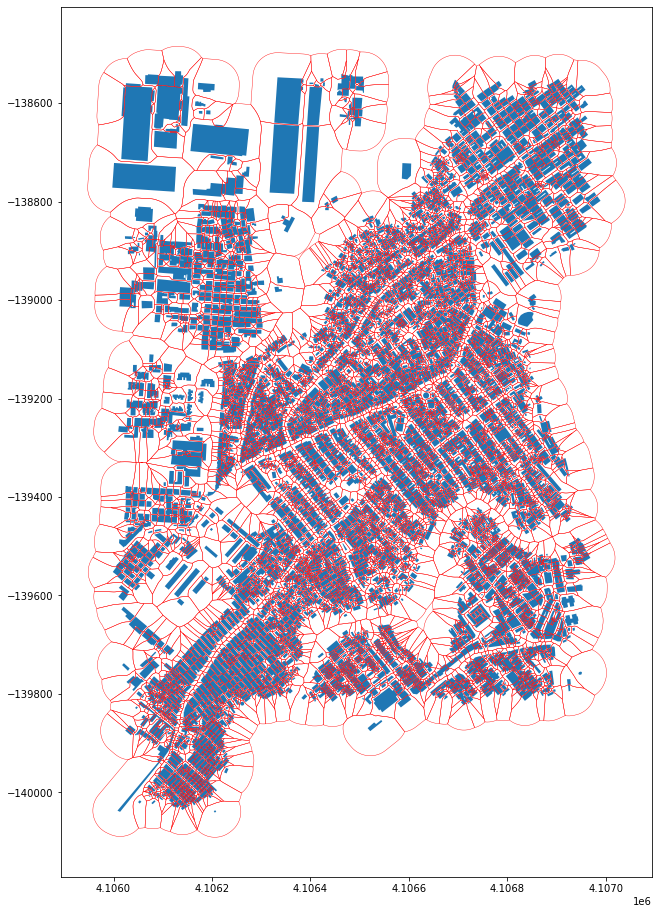

In [31]:
ax = ground_truth.plot(figsize=(16, 16))
gt_tess.plot(ax=ax, facecolor='none', edgecolor='r', linewidth=.4)

In [32]:
raw['uID'] = range(len(raw))
raw_limit = mm.buffered_limit(raw, 50)
raw_tess = mm.Tessellation(raw, 'uID', raw_limit, verbose=False).tessellation

<AxesSubplot:>

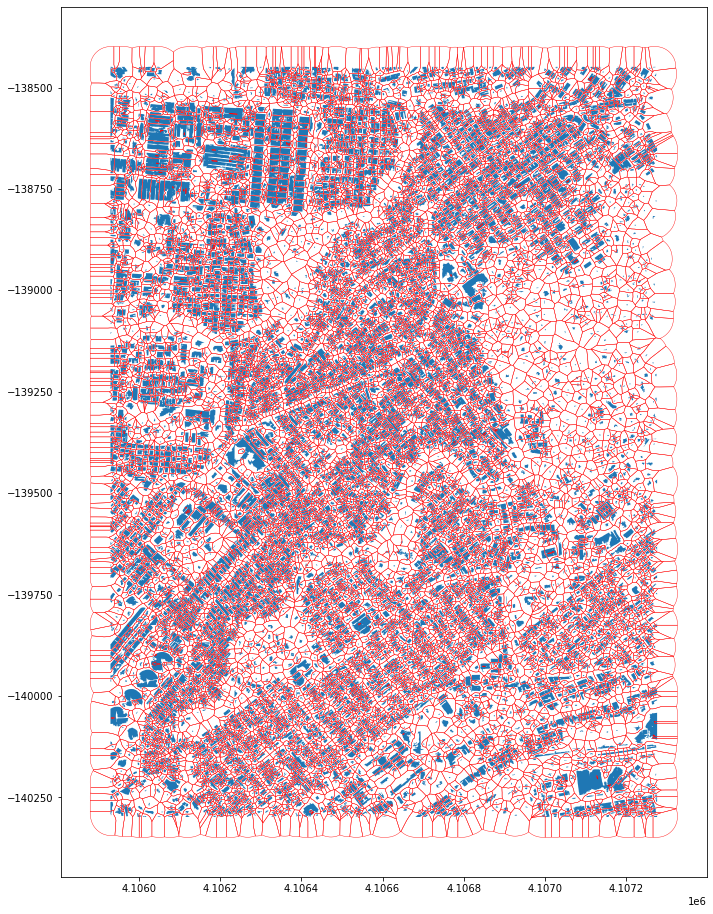

In [33]:
ax = raw.plot(figsize=(16, 16))
raw_tess.plot(ax=ax, facecolor='none', edgecolor='r', linewidth=.4)

In [34]:
clean['uID'] = range(len(clean))
clean_limit = mm.buffered_limit(clean, 50)
clean_tess = mm.Tessellation(clean, 'uID', clean_limit, verbose=False).tessellation

<AxesSubplot:>

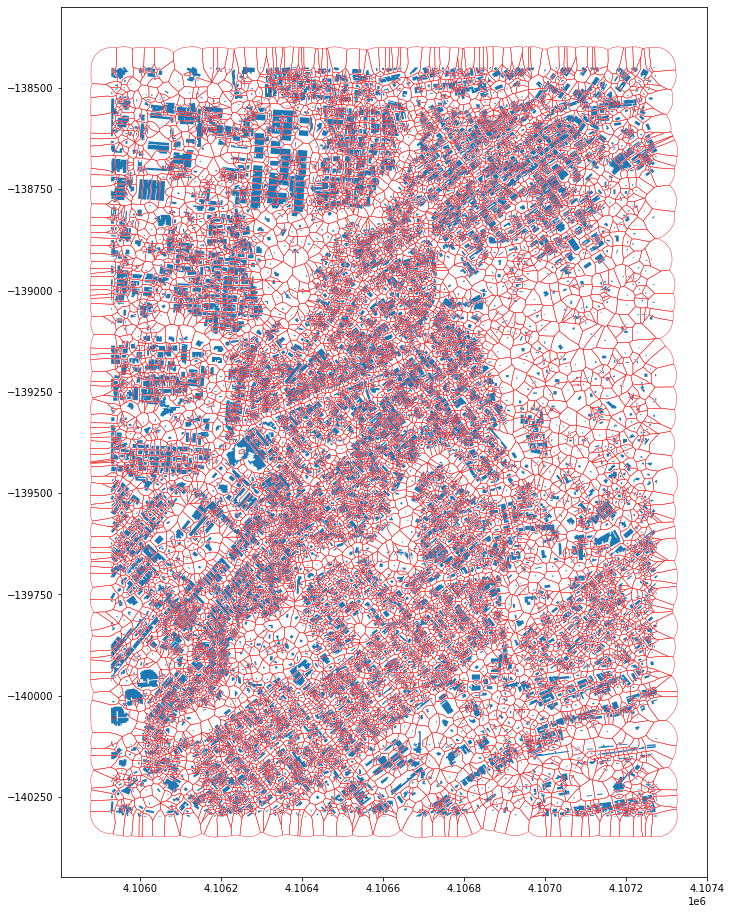

In [35]:
ax = clean.plot(figsize=(16, 16))
clean_tess.plot(ax=ax, facecolor='none', edgecolor='r', linewidth=.4)

## Measuring primary morphometric characters

We'll measure a selection which works only with building footprint and tessellation inputs.

### Ground truth data

In [36]:
# dimensions
ground_truth['sdbAre'] = mm.Area(ground_truth).series
ground_truth['sdbPer'] = mm.Perimeter(ground_truth).series

# shapes
ground_truth['ssbCCo'] = mm.CircularCompactness(ground_truth, 'sdbAre').series
ground_truth['ssbCor'] = mm.Corners(ground_truth).series
ground_truth['ssbSqu'] = mm.Squareness(ground_truth).series
ground_truth['ssbERI'] = mm.EquivalentRectangularIndex(ground_truth, 'sdbAre', 'sdbPer').series
ground_truth['ssbElo'] = mm.Elongation(ground_truth).series
cencon = mm.CentroidCorners(ground_truth)
ground_truth['ssbCCM'] = cencon.mean
ground_truth['ssbCCD'] = cencon.std

# spatial distribution
ground_truth['stbOri'] = mm.Orientation(ground_truth).series
 
gt_tess['stcOri'] = mm.Orientation(gt_tess).series
ground_truth['stbCeA'] = mm.CellAlignment(ground_truth, gt_tess, 'stbOri', 'stcOri', 'uID', 'uID').series

# tessellation dims and shapes
gt_tess['sdcLAL'] = mm.LongestAxisLength(gt_tess).series
gt_tess['sdcAre'] = mm.Area(gt_tess).series
gt_tess['sscCCo'] = mm.CircularCompactness(gt_tess, 'sdcAre').series
gt_tess['sscERI'] = mm.EquivalentRectangularIndex(gt_tess, 'sdcAre').series

# intensity
gt_tess['sicCAR'] = mm.AreaRatio(gt_tess, ground_truth, 'sdcAre', 'sdbAre', 'uID').series

 11%|█         | 836/7611 [00:00<00:01, 4211.67it/s]/opt/conda/lib/python3.7/site-packages/momepy/shape.py:766: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
 15%|█▌        | 1163/7611 [00:00<00:01, 3770.10it/s]/opt/conda/lib/python3.7/site-packages/momepy/shape.py:854: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(cosine_angle))
 14%|█▍        | 1103/7611 [00:00<00:02, 2712.57it/s]/opt/conda/lib/python3.7/site-packages/momepy/shape.py:1074: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
100%|██████████| 7611/7611 [00:13<00:00, 554.82it/s]


In [37]:
queen_1 = Queen.from_dataframe(gt_tess, ids="uID")
 
ground_truth["mtbAli"] = mm.Alignment(ground_truth, queen_1, "uID", "stbOri").series
ground_truth["mtbNDi"] = mm.NeighborDistance(ground_truth, queen_1, "uID").series
gt_tess["mtcWNe"] = mm.Neighbors(gt_tess, queen_1, "uID", weighted=True).series
gt_tess["mdcAre"] = mm.CoveredArea(gt_tess, queen_1, "uID").series

100%|██████████| 7611/7611 [00:01<00:00, 3837.36it/s]


In [38]:
ground_truth_queen = Queen.from_dataframe(ground_truth)

queen3 = mm.sw_high(k=3, weights=queen_1)

ground_truth['ltbIBD'] = mm.MeanInterbuildingDistance(ground_truth, queen_1, 'uID', queen3).series
ground_truth['ltcBuA'] = mm.BuildingAdjacency(ground_truth, queen3, 'uID', ground_truth_queen).series

/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7277 disconnected components.
 There are 7020 islands with ids: 0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 74, 75, 80, 81, 82, 83, 85, 86, 87, 88, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 102, 105, 108, 109, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198, 199, 201, 202, 203, 204

Computing mean interbuilding distances...


Calculating adjacency: 100%|██████████| 7611/7611 [00:00<00:00, 149760.73it/s]


In [41]:
gt_data = gt_tess.drop(columns='geometry').merge(ground_truth.drop(columns=['Roof', 'osm_id', 'geometry']), on='uID')
gt_data

,uID,stcOri,sdcLAL,sdcAre,sscCCo,sscERI,sicCAR,mtcWNe,mdcAre,sdbAre,...,ssbERI,ssbElo,ssbCCM,ssbCCD,stbOri,stbCeA,mtbAli,mtbNDi,ltbIBD,ltcBuA
0,0,39.687084,22.420918,194.726470,0.493206,0.940016,0.703260,0.132167,1234.399734,136.943434,...,0.954882,0.727805,7.933368,1.066596,37.951749,1.735335,1.472031,2.502296,3.036088,1.000000
1,1,33.399279,19.075128,192.382268,0.673194,1.011211,0.719791,0.145810,1236.286968,138.474981,...,0.806780,0.954461,8.497681,0.002309,35.354570,1.955292,2.292235,1.579275,5.381454,1.000000
2,2,28.698866,28.427890,191.307720,0.301407,0.803503,0.592506,0.134770,1885.961033,113.351005,...,0.606891,0.314659,9.396996,3.995149,35.578852,6.879987,3.085648,1.633346,6.712141,0.984127
3,3,19.399299,10.366547,52.549523,0.622602,1.000665,0.587920,0.239988,440.292060,30.894920,...,1.006403,0.875671,3.921350,0.054971,23.286018,3.886719,9.867303,1.385517,2.900149,0.975000
4,4,29.292255,39.241652,643.960178,0.532445,0.941996,0.358502,0.073095,3019.334683,230.861124,...,1.000031,0.643678,11.260554,0.002247,40.524017,11.231762,2.703969,9.013651,5.461746,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7606,7606,41.161147,18.543680,57.216819,0.211857,0.977156,0.422517,0.171336,1809.468226,24.175088,...,0.956224,0.129873,7.264425,0.324735,43.189351,2.028204,3.766652,0.985080,3.395754,0.965517
7607,7607,10.479259,63.275992,484.966934,0.154221,0.800988,0.234610,0.043402,4340.151039,113.778244,...,1.001261,0.230552,11.394826,0.035981,38.603096,28.123837,2.268100,1.241706,3.295453,0.983333
7608,7608,37.068192,59.842621,1101.354774,0.391576,0.875842,0.065456,0.038327,11648.569680,72.089854,...,0.996776,0.636388,6.348551,0.085675,4.600378,32.467814,4.276674,29.213448,9.130934,1.000000
7609,7609,33.415400,94.781825,4833.087975,0.684991,1.078220,0.007103,0.019195,11885.614687,34.331216,...,1.084857,0.851510,3.561339,0.241993,6.002705,27.412695,8.595841,48.805691,9.773083,0.970588


In [42]:
gt_data.to_csv('ground_truth_primary.csv')
gt_tess[['uID', 'geometry']].to_file('ground_truth.gpkg', driver='GPKG', layer='tessellation')
ground_truth[['uID', 'geometry']].to_file('ground_truth.gpkg', driver='GPKG', layer='buildings')

### Raw

In [43]:
# dimensions
raw['sdbAre'] = mm.Area(raw).series
raw['sdbPer'] = mm.Perimeter(raw).series

# shapes
raw['ssbCCo'] = mm.CircularCompactness(raw, 'sdbAre').series
raw['ssbCor'] = mm.Corners(raw).series
raw['ssbSqu'] = mm.Squareness(raw).series
raw['ssbERI'] = mm.EquivalentRectangularIndex(raw, 'sdbAre', 'sdbPer').series
raw['ssbElo'] = mm.Elongation(raw).series
cencon = mm.CentroidCorners(raw)
raw['ssbCCM'] = cencon.mean
raw['ssbCCD'] = cencon.std

# spatial distribution
raw['stbOri'] = mm.Orientation(raw).series
 
raw_tess['stcOri'] = mm.Orientation(raw_tess).series
raw['stbCeA'] = mm.CellAlignment(raw, raw_tess, 'stbOri', 'stcOri', 'uID', 'uID').series

# tessellation dims and shapes
raw_tess['sdcLAL'] = mm.LongestAxisLength(raw_tess).series
raw_tess['sdcAre'] = mm.Area(raw_tess).series
raw_tess['sscCCo'] = mm.CircularCompactness(raw_tess, 'sdcAre').series
raw_tess['sscERI'] = mm.EquivalentRectangularIndex(raw_tess, 'sdcAre').series

# intensity
raw_tess['sicCAR'] = mm.AreaRatio(raw_tess, raw, 'sdcAre', 'sdbAre', 'uID').series

queen_1 = Queen.from_dataframe(raw_tess, ids="uID")
 
raw["mtbAli"] = mm.Alignment(raw, queen_1, "uID", "stbOri").series
raw["mtbNDi"] = mm.NeighborDistance(raw, queen_1, "uID").series
raw_tess["mtcWNe"] = mm.Neighbors(raw_tess, queen_1, "uID", weighted=True).series
raw_tess["mdcAre"] = mm.CoveredArea(raw_tess, queen_1, "uID").series

raw_queen = Queen.from_dataframe(raw)

queen3 = mm.sw_high(k=3, weights=queen_1)

raw['ltbIBD'] = mm.MeanInterbuildingDistance(raw, queen_1, 'uID', queen3).series
raw['ltcBuA'] = mm.BuildingAdjacency(raw, queen3, 'uID', raw_queen).series

100%|██████████| 14059/14059 [00:03<00:00, 3952.73it/s]
/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 13834 disconnected components.
 There are 13623 islands with ids: 0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 1

Computing mean interbuilding distances...


Calculating adjacency: 100%|██████████| 14059/14059 [00:00<00:00, 152777.59it/s]


In [44]:
raw.columns

Index(['ID', 'GRIDCODE', 'geometry', 'uID', 'sdbAre', 'sdbPer', 'ssbCCo',
       'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'stbOri',
       'stbCeA', 'mtbAli', 'mtbNDi', 'ltbIBD', 'ltcBuA'],
      dtype='object')

In [45]:
raw_data = raw_tess.drop(columns='geometry').merge(raw.drop(columns=['GRIDCODE', 'ID', 'geometry']), on='uID')
raw_data

,uID,stcOri,sdcLAL,sdcAre,sscCCo,sscERI,sicCAR,mtcWNe,mdcAre,sdbAre,...,ssbERI,ssbElo,ssbCCM,ssbCCD,stbOri,stbCeA,mtbAli,mtbNDi,ltbIBD,ltcBuA
0,0,6.660432,57.436993,1105.300375,0.426586,0.995004,0.006225,0.027684,3069.940427,6.880370,...,0.867262,0.302352,2.837253,0.753708,0.000000,6.660432,8.053448,10.299919,7.068584,1.000000
1,1,0.000000,54.544978,548.982476,0.234941,1.024404,0.016191,0.032230,2353.505229,8.888630,...,0.967689,0.372234,2.376593,0.724415,0.000000,0.000000,32.425485,3.663825,8.909887,0.954545
2,2,0.163117,63.696540,2102.946852,0.659943,1.045564,0.006165,0.022726,10650.169621,12.964019,...,0.862300,0.257327,2.994001,0.926213,8.321585,8.158468,3.631730,21.884240,19.498433,1.000000
3,3,1.598458,52.425051,115.702625,0.053601,0.756784,0.055443,0.009037,1837.750745,6.414950,...,0.965720,0.568625,1.649273,0.458073,11.177879,9.579421,6.677459,0.000000,4.269326,0.928571
4,4,7.933734,84.560512,3024.469029,0.538548,1.020446,0.002422,0.009278,5869.287793,7.326355,...,0.792085,0.273756,2.491701,1.022769,10.615874,2.682140,8.991756,10.412504,14.041998,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14054,14054,8.815025,64.736733,1968.123206,0.597944,1.041182,0.014284,0.028935,4831.504795,28.112495,...,0.799133,0.631696,3.522674,0.767439,12.113167,3.298141,3.300615,15.221488,6.165255,1.000000
14055,14055,0.000000,64.281963,1908.118934,0.587946,1.016088,0.012483,0.023043,3965.424208,23.818476,...,0.896987,0.138213,5.493924,2.278615,0.000000,0.000000,6.895531,7.522210,6.098824,1.000000
14056,14056,0.000000,58.346899,1249.713827,0.467396,1.005209,0.014490,0.040089,4684.241502,18.108415,...,0.852500,0.444458,3.397586,1.183765,0.000000,0.000000,7.587777,9.595392,5.631725,1.000000
14057,14057,0.000000,56.861784,932.834566,0.367345,1.010324,0.007043,0.043351,6005.282731,6.569674,...,0.975664,0.233450,2.814233,0.120552,0.000000,0.000000,7.150787,10.718332,6.107420,1.000000


In [46]:
raw_data.to_csv('raw_primary.csv')
raw_tess[['uID', 'geometry']].to_file('raw.gpkg', driver='GPKG', layer='tessellation')
raw[['uID', 'geometry']].to_file('raw.gpkg', driver='GPKG', layer='buildings')

### Clean

In [54]:
# dimensions
clean['sdbAre'] = mm.Area(clean).series
clean['sdbPer'] = mm.Perimeter(clean).series

# shapes
clean['ssbCCo'] = mm.CircularCompactness(clean, 'sdbAre').series
clean['ssbCor'] = mm.Corners(clean).series
clean['ssbSqu'] = mm.Squareness(clean).series
clean['ssbERI'] = mm.EquivalentRectangularIndex(clean, 'sdbAre', 'sdbPer').series
clean['ssbElo'] = mm.Elongation(clean).series
cencon = mm.CentroidCorners(clean)
clean['ssbCCM'] = cencon.mean
clean['ssbCCD'] = cencon.std

# spatial distribution
clean['stbOri'] = mm.Orientation(clean).series
 
clean_tess['stcOri'] = mm.Orientation(clean_tess).series
clean['stbCeA'] = mm.CellAlignment(clean, clean_tess, 'stbOri', 'stcOri', 'uID', 'uID').series

# tessellation dims and shapes
clean_tess['sdcLAL'] = mm.LongestAxisLength(clean_tess).series
clean_tess['sdcAre'] = mm.Area(clean_tess).series
clean_tess['sscCCo'] = mm.CircularCompactness(clean_tess, 'sdcAre').series
clean_tess['sscERI'] = mm.EquivalentRectangularIndex(clean_tess, 'sdcAre').series

# intensity
clean_tess['sicCAR'] = mm.AreaRatio(clean_tess, clean, 'sdcAre', 'sdbAre', 'uID').series

queen_1 = Queen.from_dataframe(clean_tess, ids="uID")
 
clean["mtbAli"] = mm.Alignment(clean, queen_1, "uID", "stbOri").series
clean["mtbNDi"] = mm.NeighborDistance(clean, queen_1, "uID").series
clean_tess["mtcWNe"] = mm.Neighbors(clean_tess, queen_1, "uID", weighted=True).series
clean_tess["mdcAre"] = mm.CoveredArea(clean_tess, queen_1, "uID").series

clean_queen = Queen.from_dataframe(clean, silence_warnings=True)

queen3 = mm.sw_high(k=3, weights=queen_1)

clean['ltbIBD'] = mm.MeanInterbuildingDistance(clean, queen_1, 'uID', queen3).series
clean['ltcBuA'] = mm.BuildingAdjacency(clean, queen3, 'uID', clean_queen).series

  0%|          | 0/12380 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/momepy/distribution.py:621: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  adj_list.neighbor.isin(neighbours)
  0%|          | 32/12380 [00:00<00:39, 315.33it/s]

Computing mean interbuilding distances...


Calculating adjacency: 100%|██████████| 12380/12380 [00:00<00:00, 111280.26it/s]


In [55]:
clean.columns

Index(['ID', 'GRIDCODE', 'ORIG_OID', 'STATUS', 'geometry', 'uID', 'sdbAre',
       'sdbPer', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM',
       'ssbCCD', 'stbOri', 'stbCeA', 'mtbAli', 'mtbNDi', 'ltbIBD', 'ltcBuA'],
      dtype='object')

In [57]:
clean_data = clean_tess.drop(columns='geometry').merge(clean.drop(columns=['ID', 'GRIDCODE', 'ORIG_OID', 'STATUS', 'geometry']), on='uID')
clean_data

,uID,stcOri,sdcLAL,sdcAre,sscCCo,sscERI,sicCAR,mtcWNe,mdcAre,sdbAre,...,ssbERI,ssbElo,ssbCCM,ssbCCD,stbOri,stbCeA,mtbAli,mtbNDi,ltbIBD,ltcBuA
0,0,0.090188,55.047038,539.201398,0.226565,0.989216,0.009389,0.023888,2002.123608,5.06250,...,1.0,0.222222,2.444701,3.474633e-10,9.140625,9.050437,13.066406,4.810782,8.464017,1.0
1,1,6.252353,58.201514,1199.397689,0.450822,0.988917,0.004690,0.020244,2768.610113,5.62500,...,1.0,0.200000,2.704163,2.276174e-10,8.789062,2.536709,4.042969,10.157106,6.931606,1.0
2,2,1.457580,57.632857,1589.794098,0.609412,1.047731,0.006369,0.025406,4489.538298,10.12500,...,1.0,0.444444,2.611573,1.511315e-10,11.250000,9.792420,22.851563,12.987408,13.314279,1.0
3,3,0.046244,64.084019,2086.346620,0.646840,1.041191,0.005662,0.022717,10956.193068,11.81250,...,1.0,0.214286,3.796586,2.248892e-10,6.328125,6.281881,2.642239,22.447496,21.773271,1.0
4,4,4.627803,85.444598,3095.595748,0.539865,1.030002,0.002181,0.009256,5896.298432,6.75000,...,1.0,0.166667,3.225872,1.691942e-10,3.691406,0.936397,18.896484,11.571409,16.220531,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12375,12375,0.882400,58.119616,1167.305833,0.439997,1.032231,0.004337,0.034487,4846.370069,5.06250,...,1.0,0.222222,2.444701,3.570052e-10,2.636719,1.754319,8.156250,11.178392,5.821414,1.0
12376,12376,1.691725,61.450207,1755.418396,0.591894,1.041045,0.013939,0.030114,4370.628274,24.46875,...,1.0,0.103448,7.730823,1.883994e-11,1.054688,0.637037,7.382812,10.311078,6.870054,1.0
12377,12377,1.608104,57.518646,1046.301231,0.402670,0.989227,0.015053,0.034556,3740.858219,15.75000,...,1.0,0.285714,3.860861,8.701063e-10,12.656250,11.048146,7.101562,7.864666,6.086304,1.0
12378,12378,5.090681,56.799194,793.779791,0.313275,1.021100,0.007086,0.037284,5669.312699,5.62500,...,1.0,0.200000,2.704163,4.566185e-10,0.000000,5.090681,16.066406,8.912990,6.784381,1.0


In [58]:
clean_data.to_csv('clean_primary.csv')
clean_tess[['uID', 'geometry']].to_file('clean.gpkg', driver='GPKG', layer='tessellation')
clean[['uID', 'geometry']].to_file('clean.gpkg', driver='GPKG', layer='buildings')

## Plots

In [79]:
for c in clean_data.columns[1:]:
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    vmin = min([gt_data[c].min(), raw_data[c].min(), clean_data[c].min()])
    vmax = max([gt_data[c].max(), raw_data[c].max(), clean_data[c].max()])
    gt_tess.plot(gt_data[c], ax=axs[0], legend=True, vmin=vmin, vmax=vmax)
    raw_tess.plot(raw_data[c], ax=axs[1],legend=True, vmin=vmin, vmax=vmax)
    clean_tess.plot(clean_data[c], ax=axs[2], legend=True, vmin=vmin, vmax=vmax)
    axs[0].set_title('ground truth')
    axs[1].set_title('raw')
    axs[2].set_title('clean')
    fig.suptitle(c)
    plt.savefig(f'figs/{c}.png')
    plt.close()
    

## Contextual characters

Contextual characters are spatially lagged and express the tendency within the area. We will try two options - standard three topological steps and 100 distance threshold.

We will measure interquartile mean, interquartile range and interdecile Theil index of inequality.

### Ground truth

In [81]:
def theil(y):
    y = np.array(y)
    n = len(y)
    plus = y + np.finfo('float').tiny * (y == 0)  # can't have 0 values
    yt = plus.sum(axis=0)
    s = plus / (yt * 1.0)
    lns = np.log(n * s)
    slns = s * lns
    t = sum(slns)
    return t

In [80]:
means = {}
ranges = {}
theils = {}

for ch in clean_data.columns[1:]:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []

In [84]:
gt_data = gt_data.set_index('uID')

In [88]:
spatial_weights = mm.sw_high(k=3, gdf=gt_tess, ids='uID')

for i in tqdm(gt_data.index, total=len(gt_data)):
    neighbours = spatial_weights.neighbors[i].copy()
    neighbours.append(i)
    
    for ch in clean_data.columns[1:]:
        values_list = gt_data.loc[neighbours][ch]
        idec = mm.limit_range(values_list.tolist(), rng=(10, 90))
        iquar = mm.limit_range(values_list.tolist(), rng=(25, 75))
        
        means[ch].append(np.mean(iquar))
        ranges[ch].append(sp.stats.iqr(values_list, rng=(25, 75)))
        theils[ch].append(theil(idec))

In [114]:
for ch in clean_data.columns[1:]:
    try:
        gt_data[ch + '_meanIQ3'] = means[ch]
    except:
        gt_data[ch + '_meanIQ3'] = means[ch][1:]
    gt_data[ch + '_rangeIQ3'] = ranges[ch]
    gt_data[ch + '_theilID3'] = theils[ch]

### Raw

In [115]:
means = {}
ranges = {}
theils = {}

for ch in clean_data.columns[1:]:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []

raw_data = raw_data.set_index('uID')

In [116]:
spatial_weights = mm.sw_high(k=3, gdf=raw_tess, ids='uID')

for i in tqdm(raw_data.index, total=len(raw_data)):
    neighbours = spatial_weights.neighbors[i].copy()
    neighbours.append(i)
    
    for ch in clean_data.columns[1:]:
        values_list = raw_data.loc[neighbours][ch]
        idec = mm.limit_range(values_list.tolist(), rng=(10, 90))
        iquar = mm.limit_range(values_list.tolist(), rng=(25, 75))
        
        means[ch].append(np.mean(iquar))
        ranges[ch].append(sp.stats.iqr(values_list, rng=(25, 75)))
        theils[ch].append(theil(idec))

In [117]:
for ch in clean_data.columns[1:]:
    raw_data[ch + '_meanIQ3'] = means[ch]
    raw_data[ch + '_rangeIQ3'] = ranges[ch]
    raw_data[ch + '_theilID3'] = theils[ch]

### Clean

In [118]:
means = {}
ranges = {}
theils = {}

for ch in clean_data.columns[1:]:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []

clean_data = clean_data.set_index('uID')

In [120]:
spatial_weights = mm.sw_high(k=3, gdf=clean_tess, ids='uID')

for i in tqdm(clean_data.index, total=len(clean_data)):
    neighbours = spatial_weights.neighbors[i].copy()
    neighbours.append(i)
    
    for ch in clean_data.columns[1:]:
        values_list = clean_data.loc[neighbours][ch]
        idec = mm.limit_range(values_list.tolist(), rng=(10, 90))
        iquar = mm.limit_range(values_list.tolist(), rng=(25, 75))
        
        means[ch].append(np.mean(iquar))
        ranges[ch].append(sp.stats.iqr(values_list, rng=(25, 75)))
        theils[ch].append(theil(idec))

for ch in clean_data.columns[1:]:
    clean_data[ch + '_meanIQ3'] = means[ch]
    clean_data[ch + '_rangeIQ3'] = ranges[ch]
    clean_data[ch + '_theilID3'] = theils[ch]

Using distance band.

In [125]:
means = {}
ranges = {}
theils = {}

for ch in clean_data.columns[1:23]:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []

spatial_weights = DistanceBand.from_dataframe(ground_truth, 100, ids='uID')

for i in tqdm(gt_data.index, total=len(gt_data)):
    neighbours = spatial_weights.neighbors[i].copy()
    neighbours.append(i)
    
    for ch in clean_data.columns[1:23]:
        values_list = gt_data.loc[neighbours][ch]
        idec = mm.limit_range(values_list.tolist(), rng=(10, 90))
        iquar = mm.limit_range(values_list.tolist(), rng=(25, 75))
        
        means[ch].append(np.mean(iquar))
        ranges[ch].append(sp.stats.iqr(values_list, rng=(25, 75)))
        theils[ch].append(theil(idec))

for ch in clean_data.columns[1:23]:
    gt_data[ch + '_meanIQ100'] = means[ch]
    gt_data[ch + '_rangeIQ100'] = ranges[ch]
    gt_data[ch + '_theilID100'] = theils[ch]

In [126]:
means = {}
ranges = {}
theils = {}

for ch in clean_data.columns[1:23]:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []

spatial_weights = DistanceBand.from_dataframe(raw, 100, ids='uID')

for i in tqdm(raw_data.index, total=len(raw_data)):
    neighbours = spatial_weights.neighbors[i].copy()
    neighbours.append(i)
    
    for ch in clean_data.columns[1:23]:
        values_list = raw_data.loc[neighbours][ch]
        idec = mm.limit_range(values_list.tolist(), rng=(10, 90))
        iquar = mm.limit_range(values_list.tolist(), rng=(25, 75))
        
        means[ch].append(np.mean(iquar))
        ranges[ch].append(sp.stats.iqr(values_list, rng=(25, 75)))
        theils[ch].append(theil(idec))

for ch in clean_data.columns[1:23]:
    raw_data[ch + '_meanIQ100'] = means[ch]
    raw_data[ch + '_rangeIQ100'] = ranges[ch]
    raw_data[ch + '_theilID100'] = theils[ch]

In [127]:
means = {}
ranges = {}
theils = {}

for ch in clean_data.columns[1:23]:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []

spatial_weights = DistanceBand.from_dataframe(clean, 100, ids='uID')

for i in tqdm(clean_data.index, total=len(clean_data)):
    neighbours = spatial_weights.neighbors[i].copy()
    neighbours.append(i)
    
    for ch in clean_data.columns[1:23]:
        values_list = clean_data.loc[neighbours][ch]
        idec = mm.limit_range(values_list.tolist(), rng=(10, 90))
        iquar = mm.limit_range(values_list.tolist(), rng=(25, 75))
        
        means[ch].append(np.mean(iquar))
        ranges[ch].append(sp.stats.iqr(values_list, rng=(25, 75)))
        theils[ch].append(theil(idec))

for ch in clean_data.columns[1:23]:
    clean_data[ch + '_meanIQ100'] = means[ch]
    clean_data[ch + '_rangeIQ100'] = ranges[ch]
    clean_data[ch + '_theilID100'] = theils[ch]

In [128]:
cont = [c for c in clean_data.columns if '_' in c]
cont

['sdcLAL_meanIQ3',
 'sdcLAL_rangeIQ3',
 'sdcLAL_theilID3',
 'sdcAre_meanIQ3',
 'sdcAre_rangeIQ3',
 'sdcAre_theilID3',
 'sscCCo_meanIQ3',
 'sscCCo_rangeIQ3',
 'sscCCo_theilID3',
 'sscERI_meanIQ3',
 'sscERI_rangeIQ3',
 'sscERI_theilID3',
 'sicCAR_meanIQ3',
 'sicCAR_rangeIQ3',
 'sicCAR_theilID3',
 'mtcWNe_meanIQ3',
 'mtcWNe_rangeIQ3',
 'mtcWNe_theilID3',
 'mdcAre_meanIQ3',
 'mdcAre_rangeIQ3',
 'mdcAre_theilID3',
 'sdbAre_meanIQ3',
 'sdbAre_rangeIQ3',
 'sdbAre_theilID3',
 'sdbPer_meanIQ3',
 'sdbPer_rangeIQ3',
 'sdbPer_theilID3',
 'ssbCCo_meanIQ3',
 'ssbCCo_rangeIQ3',
 'ssbCCo_theilID3',
 'ssbCor_meanIQ3',
 'ssbCor_rangeIQ3',
 'ssbCor_theilID3',
 'ssbSqu_meanIQ3',
 'ssbSqu_rangeIQ3',
 'ssbSqu_theilID3',
 'ssbERI_meanIQ3',
 'ssbERI_rangeIQ3',
 'ssbERI_theilID3',
 'ssbElo_meanIQ3',
 'ssbElo_rangeIQ3',
 'ssbElo_theilID3',
 'ssbCCM_meanIQ3',
 'ssbCCM_rangeIQ3',
 'ssbCCM_theilID3',
 'ssbCCD_meanIQ3',
 'ssbCCD_rangeIQ3',
 'ssbCCD_theilID3',
 'stbOri_meanIQ3',
 'stbOri_rangeIQ3',
 'stbOri_theilID3

In [129]:
gt_data[cont].to_csv('gt_lagged.csv')
raw_data[cont].to_csv('raw_lagged.csv')
clean_data[cont].to_csv('clean_lagged.csv')

## Plots

In [130]:
for c in cont:
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    vmin = min([gt_data[c].min(), raw_data[c].min(), clean_data[c].min()])
    vmax = max([gt_data[c].max(), raw_data[c].max(), clean_data[c].max()])
    gt_tess.plot(gt_data[c], ax=axs[0], legend=True, vmin=vmin, vmax=vmax)
    raw_tess.plot(raw_data[c], ax=axs[1],legend=True, vmin=vmin, vmax=vmax)
    clean_tess.plot(clean_data[c], ax=axs[2], legend=True, vmin=vmin, vmax=vmax)
    axs[0].set_title('ground truth')
    axs[1].set_title('raw')
    axs[2].set_title('clean')
    fig.suptitle(c)
    plt.savefig(f'figs/{c}.png')
    plt.close()
    

In [132]:
import seaborn as sns

In [133]:
fmri = sns.load_dataset("fmri")

In [134]:
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
...,...,...,...,...,...
1059,s0,8,cue,frontal,0.018165
1060,s13,7,cue,frontal,-0.029130
1061,s12,7,cue,frontal,-0.004939
1062,s11,7,cue,frontal,-0.025367
